In [1]:
import torch
import torch.nn as nn
import torch.jit
import tensorrt as trt
from torch2trt import torch2trt_jit

In [2]:
class MyModule(nn.Module):
    
    def __init__(self):
        super(MyModule, self).__init__()
        self.a = torch.randn(1, 3, 1, 1).cuda()
        
    def forward(self, x):
        return x * self.a

In [3]:
model = MyModule().cuda()

data = torch.randn((1, 3, 224, 224)).cuda()

model_jit = torch.jit.trace(model, [data])

graph = model_jit.graph

In [4]:
def scalar_type_to_trt(dtype):
    if dtype == 'Float':
        return trt.float32
    elif dtype == 'Half':
        return trt.float16
    else:
        raise TypeError('%s is not supported by tensorrt' % dtype)
        

CONVERTERS_JIT = {}


def tensorrt_converter_jit(method):
    def register_converter(converter):
        CONVERTERS_JIT[method] = converter
        return converter
    return register_converter


class Node(object):
    
    def __init__(self, ctx, node):
        self.ctx = ctx
        self.node = node
        
    def inputs(self):
        return [Value(self.ctx, val) for val in self.node.inputs()]
    
    def outputs(self):
        return [Value(self.ctx, val) for val in self.node.outputs()]
    
    def scope(self):
        return self.node.scopeName()
    
    def kind(self):
        return self.node.kind()
    
    def value(self):
        return self.node.t('value')
    
    def add_layer(self, method, *args, **kwargs):
        layer = method(self.ctx.network, *args, **kwargs)
        return layer
            

class Value(object):
    
    def __init__(self, ctx, value):
        self.ctx = ctx
        self.value = value
    
    def node(self):
        return Node(self.ctx, self.value.node())
    
    def name(self):
        return self.value.debugName()
    
    def is_tensor(self):
        return self.value.isCompleteTensor()
    
    def shape(self):
        return tuple(self.value.type().sizes())
    
    def dtype_trt(self):
        return scalar_type_to_trt(self.value.type().scalarType())
    
    def get_trt(self):
        print('Val %s' % self.name())
        if self.name() in self.ctx.tensors:
            return self.ctx.tensors[self.name()]  # get tensor directly
        elif self.node().kind() in self.ctx.converters:
            print('Calling converter for %s' % self.node().kind())
            self.ctx.converters[self.node().kind()](self.node())  # attempt recursive conversion
            return self.ctx.tensors[self.name()]  # tensor should now be set...
        else:
            raise KeyError('No converter found for %s' % self.node().kind())
    
    def set_trt(self, trt_tensor):
        if self.name() not in self.ctx.tensors:
            self.ctx.tensors[self.name()] = trt_tensor
            trt_tensor.name = self.name()
        else:
            raise RuntimeException('TensorRT value already found in graph')


class Context():
    
    def __init__(self, graph, network, converters=CONVERTERS_JIT):
        self.graph = graph
        self.network = network
        self.tensors = {}
        self.converters = converters
        
            
def torch2trt_jit(module, inputs, log_level=trt.Logger.ERROR, max_batch_size=1,
        fp16_mode=False, max_workspace_size=0, strict_type_constraints=False):
    
    model_jit = torch.jit.trace(model, data)
    graph = model_jit.graph
    
    logger = trt.Logger()
    builder = trt.Builder(logger)
    
    ctx = Context(graph, builder.create_network())
    
    for output_raw in graph_outputs(graph):
        
        output = Value(ctx, output_raw)
        output_trt = output.get_trt()  # will recursively resolve tensorrt
        
        # now, ctx.trt_tensors
        ctx.network.mark_output(output_trt)
    
    builder.max_workspace_size = max_workspace_size
    builder.fp16_mode = fp16_mode
    builder.max_batch_size = max_batch_size
    builder.strict_type_constraints = strict_type_constraints

    engine = builder.build_cuda_engine(ctx.network)
        
    input_names = [Value(ctx, val).name() for val in list(graph.inputs())[1:]] # excludes 'self'
    output_names = [Value(ctx, val).name() for val in list(graph.outputs())]
    
    return TRTModule(engine=engine, input_names=input_names, output_names=output_names), ctx.network

In [5]:
@tensorrt_converter_jit('prim::Constant')
def convert_constant(node):
    output = node.outputs()[0]
    layer = node.add_layer(trt.INetworkDefinition.add_constant, output.shape()[1:], node.value().cpu().numpy())
    output.set_trt(layer.get_output(0))
    
    
@tensorrt_converter_jit('prim::Param')
def convert_param(node):
    for val in node.outputs():
        if val.is_tensor():
            input_trt = node.add_layer(trt.INetworkDefinition.add_input, val.name(), val.dtype_trt(), val.shape()[1:])
            val.set_trt(input_trt)
            
            
@tensorrt_converter_jit('aten::mul')
def convert_mul(node):
    layer = node.add_layer(trt.INetworkDefinition.add_elementwise,
        node.inputs()[0].get_trt(),
        node.inputs()[1].get_trt(),
        trt.ElementWiseOperation.PROD
    )
    node.outputs()[0].set_trt(layer.get_output(0))

In [4]:
model_trt = torch2trt_jit(model, [data])

Val 3
Calling converter for aten::mul
Val x
Calling converter for prim::Param
Val 2
Calling converter for prim::Constant


In [5]:
model_trt(data) - model(data)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

In [63]:
inp

['x']

In [64]:
oup

['3']

In [6]:
from torch2trt.utils import trt_network_to_dot_graph

In [49]:
model_jit.graph

graph(%self : ClassType<MyModule>,
      %x : Float(1, 3, 224, 224)):
  %2 : Float(1, 3, 1, 1) = prim::Constant[value=(1,1,.,.) =   -1.1015  (1,2,.,.) =   0.01 *   8.5608  (1,3,.,.) =   -0.4466 [ Variable[CPUFloatType]{1,3,1,1} ]](), scope: MyModule # <ipython-input-9-0e0d3c77cb20>:8:0
  %3 : Float(1, 3, 224, 224) = aten::mul(%x, %2), scope: MyModule # <ipython-input-9-0e0d3c77cb20>:8:0
  return (%3)

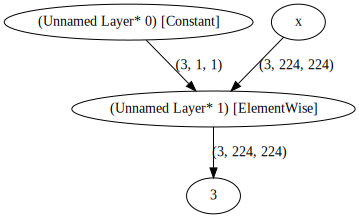

In [7]:
trt_network_to_dot_graph(model_trt.network)